# Tensor Decomposition for Passenger Flow Data

## 0. Define important funtions

In [1]:
import tensorly as tl 
from tensorly.decomposition import parafac, randomised_parafac
import numpy as np
from tensorly.decomposition import partial_tucker
import matplotlib.pyplot as plt

To define the CP decomposition on our own (though not used in the main funciton due to the mismatch of the new updated Tensorly package):

In [2]:
class parafacPCA:
    def __init__(self, dimension,nsample=1000):
        self.dimension = dimension
        self.factors = [None for i in range(3)]
        self.nsample = nsample
    def fit(self,data):
        factors = randomised_parafac(data,n_samples=self.nsample, rank=self.dimension,verbose=0)
        for k in range(0,3):
            self.factors[k] = factors[k].dot(np.diag(1/np.sqrt(np.sum(factors[k]**2,0))))

    def transform(self,data):
        ndim = data.shape[1]*data.shape[2]
        X = np.zeros((ndim,self.dimension))
        for k in range(self.dimension):
            X[:,k] = tl.kruskal_to_tensor([self.factors[1][:,[k]],self.factors[2][:,[k]]]).reshape(-1)
        beta = data.reshape(-1,ndim).dot(X).dot(np.linalg.inv(X.T.dot(X)))
        return beta
        
    def inverse_transform(self,beta):
        self.factors[0] = beta
        return tl.kruskal_to_tensor(self.factors)

To define the Tucker decomposition on our own (though not used in the main funciton due to the mismatch of the new updated Tensorly package):

In [5]:
class tuckerPCA:
    def __init__(self, dimension):
        self.dimension = dimension
        self.factors = None
    def fit(self,data):
        core, factors = partial_tucker(data,modes=[1,2],rank=[self.dimension,self.dimension])
        self.factors = factors
    def transform(self,data):
        return tl.tenalg.multi_mode_dot(data,[self.factors[0].T,self.factors[1].T],modes = [1,2])
    def inverse_transform(self,core):
        return tl.tenalg.multi_mode_dot(core,self.factors,modes = [1,2])

Define visualization functions:

In [39]:
def superlong(flow_tensor, d_start, d_end, stn):
    temp = []
    for t in range(d_start-1, d_end):
        a = flow_tensor[t,:,stn]
        temp = np.hstack((temp, a))
    return temp
        
def real_vs_recon(xtrain, train_recon, stn, day):
    a = xtrain[stn,:,day]
    b = train_recon[stn,:,day]
    x = np.linspace(1, 247, 247)
    fig = plt.figure(figsize=(6,4))
    fig.show()
    ax = fig.add_subplot(111)
    ax.plot(x, a, color = 'r', label= 'Real Data')
    ax.plot(x, b, color = 'b', label= 'Recon Data')
        
    ax.set_facecolor('w')
    ax.grid(b=None, which='major', axis='both',  color='lightgrey', linestyle='-.', linewidth=1)
    
    ax.set(xlabel="Time", ylabel=f'Passenger InFlow at STN {stn} at Day{day}')
    plt.legend(loc=0)
    plt.draw()

Define MSE metric:

In [4]:
def MSE (A, B):
    from sklearn.metrics import mean_squared_error
    # matrix A and B are rquired to be same length
    mse = mse = mean_squared_error(A, B)
    return mse

## 1. Import Data

In [46]:
import numpy as np 
data = np.load('/Users/liziyue/Desktop/source_public/data/sample_data.npy') 
data.shape

(56, 247, 90)

The tensor is formulated as $\mathcal{X}^{\text{ day} \times \text{ samples} \times \text{ station}}$, where the number of day is 56, within each day there are 247 sampling point (every 5 min one sampling point), and 90 stations.

In [47]:
#xtest = data[50:56].transpose((2,1,0))
xtrain = data[0:56].transpose((2,1,0))
xtrain.shape

(90, 247, 56)

We transpose the tensor into $\mathcal{X}^{\text{ station} \times \text{ samples} \times \text{ day}}$.

## 2. Decomposition

### 2.1 CP Decomposition

In [ ]:
cppca = parafacPCA(90,nsample=90)
#cppca = parafacPCA(50,nsample=90)
cppca.fit(xtrain)

In [13]:
factors = parafac(xtrain, rank=50) 

2

Caculate the reconstruction loss

In [14]:
train_recon = tl.cp_to_tensor(factors)

In [42]:
train_recon_score = np.sum(np.sum((xtrain-train_recon)**2,2),1)
train_recon_score
#print(train_recon_score)

array([19302602.96704155, 14386783.47063364, 21896744.35704261,
       11399610.86456845, 11147137.87935499, 20564204.80163389,
        5891884.41228237, 18433768.25830153,  6004635.60624209,
       14003619.56635829,  8036462.11711115, 11862740.77218534,
       17912222.7707603 ,  5192024.53049469, 13720228.2153754 ,
       12361154.37363416, 12280245.84497621,  9455538.23351253,
       14035205.71257179,  8651314.01665574,  3557211.36414696,
       12292913.32247763,  5806390.8845281 ,  2164975.39275138,
       11037452.00390425,  9961527.67352349, 20041626.6754221 ,
       23359676.68215928,  8232261.12128637,  5223138.6408737 ,
        8619768.81911111,  8432498.67882663,  8478670.49567647,
        3233141.00713619,  5322591.58843665,  4520557.14660184,
        7386218.69912236,  9802297.43276399, 11980442.62890981,
        3468213.03373161,  4377618.10689324, 10630401.50363084,
       12499599.75248889,  8110461.28985893,  9647296.37048151,
       11885400.15391101,  8039376.10488

The reconstruction loss is a vector with the length = the first dimension (90)

In [43]:
sum(train_recon_score)

974673992.2903252

To pick one station at a specifc day for visualization

The MSE for this station at this day is 482.4376426256094


/var/folders/s4/lnxdprt905d64l9tbd6w64f14kfqnp/T/ipykernel_13336/2969030857.py:13: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
/var/folders/s4/lnxdprt905d64l9tbd6w64f14kfqnp/T/ipykernel_13336/2969030857.py:19: MatplotlibDeprecationWarning: The 'b' parameter of grid() has been renamed 'visible' since Matplotlib 3.5; support for the old name will be dropped two minor releases later.
  ax.grid(b=None, which='major', axis='both',  color='lightgrey', linestyle='-.', linewidth=1)


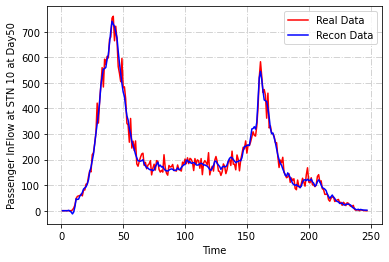

In [40]:
a = xtrain[10,:,50]
b = train_recon[10,:,50]
real_vs_recon(xtrain, train_recon, stn=10, day=50)
mse = MSE(a,b)
print(f'The MSE for this station at this day is {mse}')

To visualize the learned mode matrices:

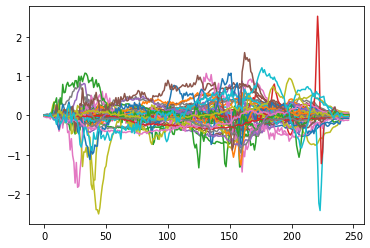

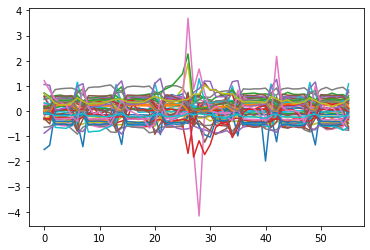

In [37]:
cpfactor0 = factors[1][0]
cpfactor1 = factors[1][1]
cpfactor2 = factors[1][2]

plt.plot(cpfactor1)
plt.figure()
plt.plot(cpfactor2)

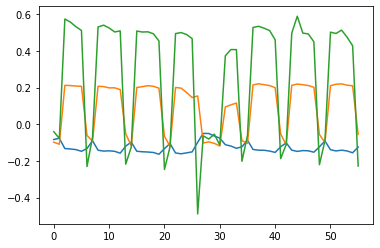

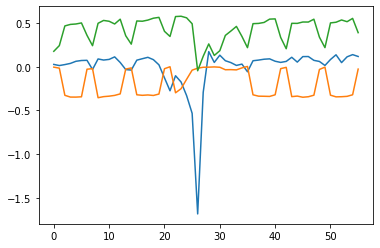

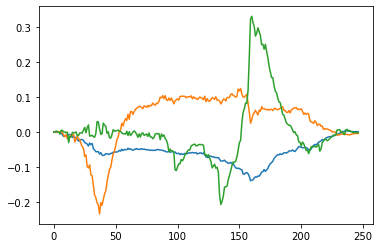

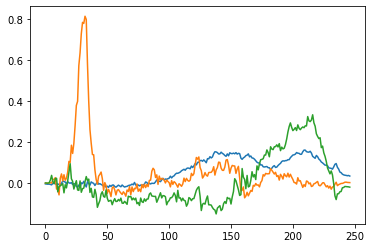

In [24]:
f = plt.figure()
for i in range(0,3):
    plt.plot(cpfactor2[:,i])

f = plt.figure()
for i in range(3,6):
    plt.plot(cpfactor2[:,i])

f = plt.figure()
for i in range(0,3):
    plt.plot(cpfactor1[:,i])

f = plt.figure()
for i in range(3,6):
    plt.plot(cpfactor1[:,i])

To visualize the the learned day-matrix day by day

/var/folders/s4/lnxdprt905d64l9tbd6w64f14kfqnp/T/ipykernel_13336/546061522.py:5: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


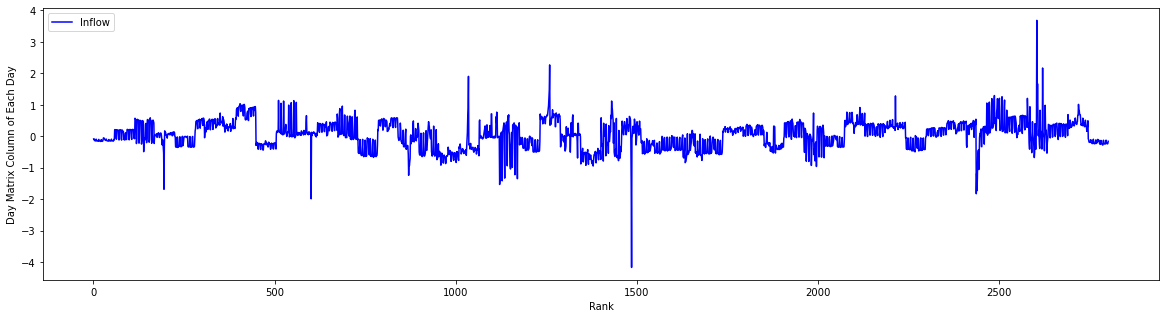

In [26]:
a = cpfactor2[:,0:56].transpose().flatten()

x = np.linspace(1, len(a), len(a))
fig = plt.figure(figsize=(20,5))
fig.show()
ax = fig.add_subplot(111)
#ax.set_facecolor('w')
ax.plot(x, a, color = 'b', label= 'Inflow')
ax.set(xlabel="Rank", ylabel="Day Matrix Column of Each Day")
plt.legend(loc=2)
plt.draw()